### Model overfitting
Размер тренировочного набора: 1000 (маленький размер выбран для демонстрации переобучения)

Размер валидационного набора: 10000

Модели состоят из 9 полносвязных слоев с 32 нейронами в каждом, в качестве функции активации используется гиперболический тангенс

В некоторые модели так же добавлены батч-нормализация и дропаут

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 50
neuNum = 32

In [3]:
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, train=1000)

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0., neuNum=128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, neuNum)
        self.fc2 = nn.Linear(neuNum, neuNum)
        self.fc3 = nn.Linear(neuNum, neuNum)
        self.fc4 = nn.Linear(neuNum, neuNum)
        self.fc5 = nn.Linear(neuNum, neuNum)
        self.fc6 = nn.Linear(neuNum, neuNum)
        self.fc7 = nn.Linear(neuNum, neuNum)
        self.fc8 = nn.Linear(neuNum, neuNum)        
        self.fc9 = nn.Linear(neuNum, 10)
        if batchnorm:
            self.bn1 = nn.BatchNorm1d(neuNum)
            self.bn2 = nn.BatchNorm1d(neuNum)
            self.bn3 = nn.BatchNorm1d(neuNum)
            self.bn4 = nn.BatchNorm1d(neuNum)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn1(x)
        x = F.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.tanh(self.fc3(x))
        
        if self.batchnorm:
            x = self.bn2(x)
        x = F.tanh(self.fc4(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.tanh(self.fc5(x))   
        
        if self.batchnorm:
            x = self.bn3(x)
        x = F.tanh(self.fc6(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.tanh(self.fc7(x))         

        if self.batchnorm:
            x = self.bn4(x)
        x = F.tanh(self.fc8(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc9(x)              
        
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def test(models, loader, log=None, Name='Test'):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data.to(device))
                test_loss[k] += m.loss(output, target.to(device), reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = Name+' set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data.to(device))
            loss = model.loss(output, target.to(device))
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    test(models, train_loader, log, 'Train')

In [7]:
models = {'default': Net(False, False, neuNum=neuNum).to(device), 'bn': Net(True, False, neuNum=neuNum).to(device), 'drop': Net(False, True, neuNum=neuNum).to(device), 'both': Net(True, True, neuNum=neuNum).to(device)}
# models = {'default': Net(False, False, neuNum=neuNum).to(device), 'both': Net(True, True, neuNum=neuNum).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
for epoch in range(1, 201):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [0/1000 (0%)]	Losses default: 2.301973 bn: 2.330173 drop: 2.283335 both: 2.309944
Train Epoch: 1 [1000/1000 (100%)]	Losses default: 2.311839 bn: 2.245655 drop: 2.348113 both: 2.201824
Train set:
default: Loss: 2.3044	Accuracy: 100/1000 (10%)
bn: Loss: 2.2116	Accuracy: 234/1000 (23%)
drop: Loss: 2.3140	Accuracy: 93/1000 (9%)
both: Loss: 2.1834	Accuracy: 273/1000 (27%)

Test set:
default: Loss: 2.3058	Accuracy: 988/10000 (9%)
bn: Loss: 2.2518	Accuracy: 1535/10000 (15%)
drop: Loss: 2.3135	Accuracy: 937/10000 (9%)
both: Loss: 2.2406	Accuracy: 1530/10000 (15%)

Train Epoch: 2 [0/1000 (0%)]	Losses default: 2.287822 bn: 2.190088 drop: 2.293609 both: 2.181113
Train Epoch: 2 [1000/1000 (100%)]	Losses default: 2.279610 bn: 2.118050 drop: 2.338473 both: 2.148929
Train set:
default: Loss: 2.2968	Accuracy: 100/1000 (10%)
bn: Loss: 2.1182	Accuracy: 341/1000 (34%)
drop: Loss: 2.3081	Accuracy: 93/1000 (9%)
both: Loss: 2.1076	Accuracy: 414/1000 (41%)

Test set:
default: Loss: 2.2986	Accu

Train Epoch: 15 [1000/1000 (100%)]	Losses default: 1.709908 bn: 1.468904 drop: 1.732868 both: 1.552741
Train set:
default: Loss: 1.7115	Accuracy: 493/1000 (49%)
bn: Loss: 1.4443	Accuracy: 886/1000 (88%)
drop: Loss: 1.6999	Accuracy: 393/1000 (39%)
both: Loss: 1.5522	Accuracy: 808/1000 (80%)

Test set:
default: Loss: 1.7631	Accuracy: 4567/10000 (45%)
bn: Loss: 1.4879	Accuracy: 8348/10000 (83%)
drop: Loss: 1.7334	Accuracy: 3753/10000 (37%)
both: Loss: 1.6048	Accuracy: 7475/10000 (74%)

Train Epoch: 16 [0/1000 (0%)]	Losses default: 1.757233 bn: 1.418460 drop: 1.711865 both: 1.499297
Train Epoch: 16 [1000/1000 (100%)]	Losses default: 1.673734 bn: 1.377339 drop: 1.679784 both: 1.506636
Train set:
default: Loss: 1.6658	Accuracy: 518/1000 (51%)
bn: Loss: 1.3917	Accuracy: 901/1000 (90%)
drop: Loss: 1.6589	Accuracy: 398/1000 (39%)
both: Loss: 1.5072	Accuracy: 817/1000 (81%)

Test set:
default: Loss: 1.7215	Accuracy: 5009/10000 (50%)
bn: Loss: 1.4601	Accuracy: 8409/10000 (84%)
drop: Loss: 1.6973	

Train Epoch: 29 [1000/1000 (100%)]	Losses default: 1.309402 bn: 1.000091 drop: 1.454406 both: 1.092563
Train set:
default: Loss: 1.2448	Accuracy: 673/1000 (67%)
bn: Loss: 0.9417	Accuracy: 950/1000 (95%)
drop: Loss: 1.3042	Accuracy: 523/1000 (52%)
both: Loss: 1.0554	Accuracy: 917/1000 (91%)

Test set:
default: Loss: 1.4124	Accuracy: 5777/10000 (57%)
bn: Loss: 1.0675	Accuracy: 8647/10000 (86%)
drop: Loss: 1.4262	Accuracy: 4760/10000 (47%)
both: Loss: 1.1838	Accuracy: 8166/10000 (81%)

Train Epoch: 30 [0/1000 (0%)]	Losses default: 1.207627 bn: 0.933192 drop: 1.264953 both: 1.045236
Train Epoch: 30 [1000/1000 (100%)]	Losses default: 1.174451 bn: 0.846944 drop: 1.245082 both: 1.007448
Train set:
default: Loss: 1.2229	Accuracy: 686/1000 (68%)
bn: Loss: 0.9046	Accuracy: 951/1000 (95%)
drop: Loss: 1.2814	Accuracy: 541/1000 (54%)
both: Loss: 1.0158	Accuracy: 911/1000 (91%)

Test set:
default: Loss: 1.3986	Accuracy: 5820/10000 (58%)
bn: Loss: 1.0443	Accuracy: 8662/10000 (86%)
drop: Loss: 1.4132	

Train Epoch: 43 [1000/1000 (100%)]	Losses default: 0.924605 bn: 0.551769 drop: 0.985157 both: 0.615878
Train set:
default: Loss: 0.9839	Accuracy: 736/1000 (73%)
bn: Loss: 0.5722	Accuracy: 980/1000 (98%)
drop: Loss: 0.9924	Accuracy: 751/1000 (75%)
both: Loss: 0.6691	Accuracy: 974/1000 (97%)

Test set:
default: Loss: 1.2709	Accuracy: 6094/10000 (60%)
bn: Loss: 0.7980	Accuracy: 8699/10000 (86%)
drop: Loss: 1.2257	Accuracy: 6479/10000 (64%)
both: Loss: 0.8846	Accuracy: 8488/10000 (84%)

Train Epoch: 44 [0/1000 (0%)]	Losses default: 0.965901 bn: 0.582544 drop: 1.031441 both: 0.657655
Train Epoch: 44 [1000/1000 (100%)]	Losses default: 0.968687 bn: 0.550154 drop: 0.904787 both: 0.679919
Train set:
default: Loss: 0.9683	Accuracy: 740/1000 (74%)
bn: Loss: 0.5631	Accuracy: 981/1000 (98%)
drop: Loss: 0.9704	Accuracy: 757/1000 (75%)
both: Loss: 0.6472	Accuracy: 976/1000 (97%)

Test set:
default: Loss: 1.2630	Accuracy: 6076/10000 (60%)
bn: Loss: 0.7820	Accuracy: 8698/10000 (86%)
drop: Loss: 1.2119	

Train Epoch: 57 [1000/1000 (100%)]	Losses default: 0.731473 bn: 0.329165 drop: 0.672831 both: 0.393325
Train set:
default: Loss: 0.8090	Accuracy: 839/1000 (83%)
bn: Loss: 0.3448	Accuracy: 997/1000 (99%)
drop: Loss: 0.7253	Accuracy: 865/1000 (86%)
both: Loss: 0.4089	Accuracy: 993/1000 (99%)

Test set:
default: Loss: 1.2032	Accuracy: 6486/10000 (64%)
bn: Loss: 0.6526	Accuracy: 8694/10000 (86%)
drop: Loss: 1.0572	Accuracy: 7152/10000 (71%)
both: Loss: 0.7076	Accuracy: 8583/10000 (85%)

Train Epoch: 58 [0/1000 (0%)]	Losses default: 0.751887 bn: 0.305895 drop: 0.678104 both: 0.369266
Train Epoch: 58 [1000/1000 (100%)]	Losses default: 0.787562 bn: 0.322288 drop: 0.684989 both: 0.385095
Train set:
default: Loss: 0.7993	Accuracy: 816/1000 (81%)
bn: Loss: 0.3471	Accuracy: 997/1000 (99%)
drop: Loss: 0.7116	Accuracy: 866/1000 (86%)
both: Loss: 0.4072	Accuracy: 995/1000 (99%)

Test set:
default: Loss: 1.2056	Accuracy: 6429/10000 (64%)
bn: Loss: 0.6442	Accuracy: 8674/10000 (86%)
drop: Loss: 1.0523	

Train Epoch: 71 [1000/1000 (100%)]	Losses default: 0.717498 bn: 0.243954 drop: 0.518444 both: 0.288363
Train set:
default: Loss: 0.6626	Accuracy: 885/1000 (88%)
bn: Loss: 0.2208	Accuracy: 998/1000 (99%)
drop: Loss: 0.5260	Accuracy: 917/1000 (91%)
both: Loss: 0.2646	Accuracy: 998/1000 (99%)

Test set:
default: Loss: 1.1715	Accuracy: 6776/10000 (67%)
bn: Loss: 0.5686	Accuracy: 8661/10000 (86%)
drop: Loss: 0.9586	Accuracy: 7463/10000 (74%)
both: Loss: 0.6095	Accuracy: 8574/10000 (85%)

Train Epoch: 72 [0/1000 (0%)]	Losses default: 0.695009 bn: 0.228498 drop: 0.550957 both: 0.274670
Train Epoch: 72 [1000/1000 (100%)]	Losses default: 0.712329 bn: 0.253265 drop: 0.476817 both: 0.290790
Train set:
default: Loss: 0.6511	Accuracy: 889/1000 (88%)
bn: Loss: 0.2101	Accuracy: 1000/1000 (100%)
drop: Loss: 0.5133	Accuracy: 920/1000 (92%)
both: Loss: 0.2513	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1689	Accuracy: 6767/10000 (67%)
bn: Loss: 0.5667	Accuracy: 8683/10000 (86%)
drop: Loss: 0.9

Train Epoch: 85 [1000/1000 (100%)]	Losses default: 0.648136 bn: 0.166054 drop: 0.445517 both: 0.213668
Train set:
default: Loss: 0.5336	Accuracy: 898/1000 (89%)
bn: Loss: 0.1457	Accuracy: 999/1000 (99%)
drop: Loss: 0.3885	Accuracy: 957/1000 (95%)
both: Loss: 0.1750	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1391	Accuracy: 6893/10000 (68%)
bn: Loss: 0.5253	Accuracy: 8662/10000 (86%)
drop: Loss: 0.8970	Accuracy: 7681/10000 (76%)
both: Loss: 0.5518	Accuracy: 8588/10000 (85%)

Train Epoch: 86 [0/1000 (0%)]	Losses default: 0.497684 bn: 0.139263 drop: 0.349972 both: 0.165858
Train Epoch: 86 [1000/1000 (100%)]	Losses default: 0.631625 bn: 0.164059 drop: 0.453263 both: 0.214623
Train set:
default: Loss: 0.5242	Accuracy: 903/1000 (90%)
bn: Loss: 0.1379	Accuracy: 999/1000 (99%)
drop: Loss: 0.3795	Accuracy: 961/1000 (96%)
both: Loss: 0.1671	Accuracy: 998/1000 (99%)

Test set:
default: Loss: 1.1345	Accuracy: 6897/10000 (68%)
bn: Loss: 0.5200	Accuracy: 8674/10000 (86%)
drop: Loss: 0.893

Train Epoch: 99 [1000/1000 (100%)]	Losses default: 0.621549 bn: 0.098986 drop: 0.324594 both: 0.126448
Train set:
default: Loss: 0.4244	Accuracy: 977/1000 (97%)
bn: Loss: 0.0992	Accuracy: 1000/1000 (100%)
drop: Loss: 0.2856	Accuracy: 987/1000 (98%)
both: Loss: 0.1201	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1120	Accuracy: 7093/10000 (70%)
bn: Loss: 0.4972	Accuracy: 8682/10000 (86%)
drop: Loss: 0.8599	Accuracy: 7855/10000 (78%)
both: Loss: 0.5211	Accuracy: 8583/10000 (85%)

Train Epoch: 100 [0/1000 (0%)]	Losses default: 0.393372 bn: 0.097683 drop: 0.299949 both: 0.123451
Train Epoch: 100 [1000/1000 (100%)]	Losses default: 0.346606 bn: 0.107025 drop: 0.241261 both: 0.119392
Train set:
default: Loss: 0.4165	Accuracy: 980/1000 (98%)
bn: Loss: 0.0993	Accuracy: 1000/1000 (100%)
drop: Loss: 0.2778	Accuracy: 989/1000 (98%)
both: Loss: 0.1164	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1108	Accuracy: 7109/10000 (71%)
bn: Loss: 0.5037	Accuracy: 8661/10000 (86%)
drop: Los

Train Epoch: 113 [1000/1000 (100%)]	Losses default: 0.348618 bn: 0.069291 drop: 0.207152 both: 0.086899
Train set:
default: Loss: 0.3382	Accuracy: 992/1000 (99%)
bn: Loss: 0.0746	Accuracy: 1000/1000 (100%)
drop: Loss: 0.2037	Accuracy: 995/1000 (99%)
both: Loss: 0.0890	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1089	Accuracy: 7181/10000 (71%)
bn: Loss: 0.4860	Accuracy: 8665/10000 (86%)
drop: Loss: 0.8367	Accuracy: 7964/10000 (79%)
both: Loss: 0.5072	Accuracy: 8572/10000 (85%)

Train Epoch: 114 [0/1000 (0%)]	Losses default: 0.313436 bn: 0.068245 drop: 0.198559 both: 0.077939
Train Epoch: 114 [1000/1000 (100%)]	Losses default: 0.318170 bn: 0.066254 drop: 0.214329 both: 0.082599
Train set:
default: Loss: 0.3327	Accuracy: 992/1000 (99%)
bn: Loss: 0.0739	Accuracy: 999/1000 (99%)
drop: Loss: 0.1990	Accuracy: 995/1000 (99%)
both: Loss: 0.0856	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1088	Accuracy: 7213/10000 (72%)
bn: Loss: 0.4874	Accuracy: 8664/10000 (86%)
drop: Loss

Train Epoch: 127 [1000/1000 (100%)]	Losses default: 0.248141 bn: 0.052137 drop: 0.148293 both: 0.061572
Train set:
default: Loss: 0.2686	Accuracy: 995/1000 (99%)
bn: Loss: 0.0741	Accuracy: 993/1000 (99%)
drop: Loss: 0.1489	Accuracy: 999/1000 (99%)
both: Loss: 0.0732	Accuracy: 998/1000 (99%)

Test set:
default: Loss: 1.1013	Accuracy: 7260/10000 (72%)
bn: Loss: 0.4873	Accuracy: 8652/10000 (86%)
drop: Loss: 0.8258	Accuracy: 8006/10000 (80%)
both: Loss: 0.5032	Accuracy: 8553/10000 (85%)

Train Epoch: 128 [0/1000 (0%)]	Losses default: 0.256746 bn: 0.057121 drop: 0.136348 both: 0.069905
Train Epoch: 128 [1000/1000 (100%)]	Losses default: 0.337755 bn: 0.064359 drop: 0.166479 both: 0.059016
Train set:
default: Loss: 0.2639	Accuracy: 995/1000 (99%)
bn: Loss: 0.0565	Accuracy: 1000/1000 (100%)
drop: Loss: 0.1457	Accuracy: 999/1000 (99%)
both: Loss: 0.0651	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1034	Accuracy: 7265/10000 (72%)
bn: Loss: 0.4827	Accuracy: 8656/10000 (86%)
drop: Loss: 

Train Epoch: 141 [1000/1000 (100%)]	Losses default: 0.204119 bn: 0.040189 drop: 0.110114 both: 0.056748
Train set:
default: Loss: 0.2150	Accuracy: 997/1000 (99%)
bn: Loss: 0.0419	Accuracy: 1000/1000 (100%)
drop: Loss: 0.1120	Accuracy: 1000/1000 (100%)
both: Loss: 0.0492	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1208	Accuracy: 7282/10000 (72%)
bn: Loss: 0.4916	Accuracy: 8630/10000 (86%)
drop: Loss: 0.8355	Accuracy: 8019/10000 (80%)
both: Loss: 0.4900	Accuracy: 8587/10000 (85%)

Train Epoch: 142 [0/1000 (0%)]	Losses default: 0.218350 bn: 0.044606 drop: 0.117257 both: 0.049072
Train Epoch: 142 [1000/1000 (100%)]	Losses default: 0.204670 bn: 0.043023 drop: 0.110667 both: 0.054754
Train set:
default: Loss: 0.2118	Accuracy: 997/1000 (99%)
bn: Loss: 0.0438	Accuracy: 1000/1000 (100%)
drop: Loss: 0.1100	Accuracy: 1000/1000 (100%)
both: Loss: 0.0500	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1200	Accuracy: 7278/10000 (72%)
bn: Loss: 0.4956	Accuracy: 8623/10000 (86%)
drop

Train Epoch: 155 [1000/1000 (100%)]	Losses default: 0.159308 bn: 0.033173 drop: 0.084630 both: 0.045645
Train set:
default: Loss: 0.1783	Accuracy: 997/1000 (99%)
bn: Loss: 0.0331	Accuracy: 1000/1000 (100%)
drop: Loss: 0.0872	Accuracy: 1000/1000 (100%)
both: Loss: 0.0390	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1362	Accuracy: 7276/10000 (72%)
bn: Loss: 0.4879	Accuracy: 8634/10000 (86%)
drop: Loss: 0.8472	Accuracy: 8009/10000 (80%)
both: Loss: 0.4933	Accuracy: 8586/10000 (85%)

Train Epoch: 156 [0/1000 (0%)]	Losses default: 0.165678 bn: 0.029224 drop: 0.091943 both: 0.035301
Train Epoch: 156 [1000/1000 (100%)]	Losses default: 0.162919 bn: 0.026666 drop: 0.082867 both: 0.031021
Train set:
default: Loss: 0.1775	Accuracy: 996/1000 (99%)
bn: Loss: 0.0321	Accuracy: 1000/1000 (100%)
drop: Loss: 0.0858	Accuracy: 1000/1000 (100%)
both: Loss: 0.0369	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1347	Accuracy: 7269/10000 (72%)
bn: Loss: 0.4828	Accuracy: 8644/10000 (86%)
drop

Train Epoch: 169 [1000/1000 (100%)]	Losses default: 0.250496 bn: 0.025316 drop: 0.073847 both: 0.029685
Train set:
default: Loss: 0.1482	Accuracy: 997/1000 (99%)
bn: Loss: 0.0316	Accuracy: 999/1000 (99%)
drop: Loss: 0.0693	Accuracy: 1000/1000 (100%)
both: Loss: 0.0330	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1534	Accuracy: 7288/10000 (72%)
bn: Loss: 0.4843	Accuracy: 8643/10000 (86%)
drop: Loss: 0.8634	Accuracy: 8007/10000 (80%)
both: Loss: 0.5028	Accuracy: 8557/10000 (85%)

Train Epoch: 170 [0/1000 (0%)]	Losses default: 0.143911 bn: 0.025624 drop: 0.074920 both: 0.030872
Train Epoch: 170 [1000/1000 (100%)]	Losses default: 0.140161 bn: 0.026925 drop: 0.071723 both: 0.029008
Train set:
default: Loss: 0.1463	Accuracy: 997/1000 (99%)
bn: Loss: 0.0262	Accuracy: 1000/1000 (100%)
drop: Loss: 0.0682	Accuracy: 1000/1000 (100%)
both: Loss: 0.0299	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1564	Accuracy: 7287/10000 (72%)
bn: Loss: 0.4929	Accuracy: 8631/10000 (86%)
drop: 

Train Epoch: 183 [1000/1000 (100%)]	Losses default: 0.121290 bn: 0.018417 drop: 0.058120 both: 0.024270
Train set:
default: Loss: 0.1257	Accuracy: 997/1000 (99%)
bn: Loss: 0.0222	Accuracy: 1000/1000 (100%)
drop: Loss: 0.0559	Accuracy: 1000/1000 (100%)
both: Loss: 0.0250	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1761	Accuracy: 7291/10000 (72%)
bn: Loss: 0.4868	Accuracy: 8651/10000 (86%)
drop: Loss: 0.8829	Accuracy: 7998/10000 (79%)
both: Loss: 0.5060	Accuracy: 8551/10000 (85%)

Train Epoch: 184 [0/1000 (0%)]	Losses default: 0.161489 bn: 0.020350 drop: 0.053546 both: 0.021500
Train Epoch: 184 [1000/1000 (100%)]	Losses default: 0.118127 bn: 0.018922 drop: 0.056777 both: 0.023042
Train set:
default: Loss: 0.1242	Accuracy: 997/1000 (99%)
bn: Loss: 0.0227	Accuracy: 1000/1000 (100%)
drop: Loss: 0.0551	Accuracy: 1000/1000 (100%)
both: Loss: 0.0256	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1787	Accuracy: 7291/10000 (72%)
bn: Loss: 0.4953	Accuracy: 8634/10000 (86%)
drop

Train Epoch: 197 [1000/1000 (100%)]	Losses default: 0.196602 bn: 0.020578 drop: 0.042432 both: 0.022540
Train set:
default: Loss: 0.1049	Accuracy: 998/1000 (99%)
bn: Loss: 0.0190	Accuracy: 1000/1000 (100%)
drop: Loss: 0.0456	Accuracy: 1000/1000 (100%)
both: Loss: 0.0201	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.1985	Accuracy: 7322/10000 (73%)
bn: Loss: 0.4986	Accuracy: 8637/10000 (86%)
drop: Loss: 0.9016	Accuracy: 7985/10000 (79%)
both: Loss: 0.5268	Accuracy: 8499/10000 (84%)

Train Epoch: 198 [0/1000 (0%)]	Losses default: 0.200641 bn: 0.016789 drop: 0.044055 both: 0.021239
Train Epoch: 198 [1000/1000 (100%)]	Losses default: 0.093684 bn: 0.015644 drop: 0.045605 both: 0.016926
Train set:
default: Loss: 0.1037	Accuracy: 998/1000 (99%)
bn: Loss: 0.0177	Accuracy: 1000/1000 (100%)
drop: Loss: 0.0450	Accuracy: 1000/1000 (100%)
both: Loss: 0.0202	Accuracy: 1000/1000 (100%)

Test set:
default: Loss: 1.2020	Accuracy: 7317/10000 (73%)
bn: Loss: 0.4962	Accuracy: 8639/10000 (86%)
drop

In [9]:
import matplotlib.pyplot as plt

Из графика ошибок видно, что ошибка всех моделей на тренировочном наборе с течением эпох стремится к 0.

Начиная с 25 эпохи ошибка моделей на тестовом наборе начинает отклонятся от ошибки соотвествующих моделей на тренировочном наборе.

На эпохах 100-125 ошибки на тестовом наборе практически перестают изменятся, у моделей 'default' и 'drop' ошибки начинают увеличиваться.

Судя по графикам, у моделей с батч-нормализацией ошибка уменьшается быстрее (обучаются быстрее). Если взять уровень ошибки 0.1015 (train loss у 'default' модели на последней эпохе) и посмотреть соответствующие ошибки на тестовом наборе у различных моделей, то окажется, что ошибки сильно отличаются. Получается, что при одинаковой ошибке на тренировочном наборе обобщающая способность моделей отличается. Лучше всего с обобщением справились модели с батч-нормализацией. Модель с дропаутом так же лучше обобщает, чем модель без дропаута и батч-нормализации.

не совсем корректно делать выводы на основе одного прогона, но некоторые предварительные гипотезы сделать можно :)

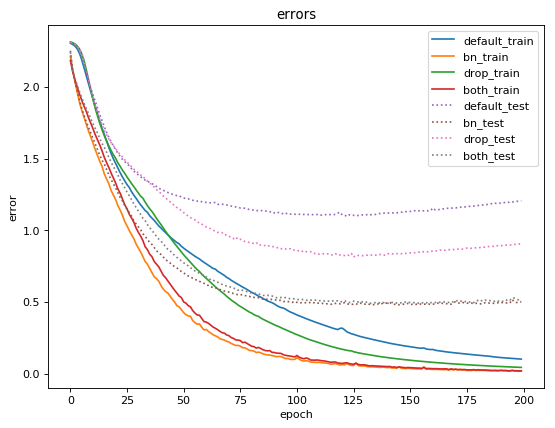

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_graphs(train_log, test_log, 'loss')

Из графика точности так же видно, что модели с батч-нормализацией учат тренировочный набор быстрее моделей без нее.

Начиная с 100 эпохи точность на тренировочном наборе практически равна 100%. Но на тестовом наборе точность намного хуже. 

Лучше всего себя показали модели с батч-нормализацией - точность 85-86% (начиная с 50 эпохи). Хуже всего модель 'default' - точность 73%. У модели с дропаутом точность 79%.

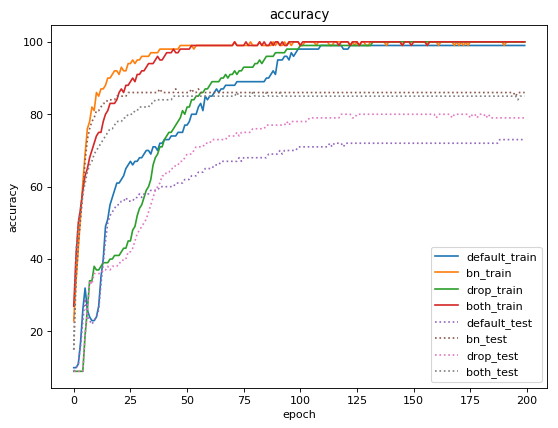

In [11]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_graphs(train_log, test_log, 'accuracy')